# CT 복원영상에서 폐, 기도, 심장을 가이드 해주는 딥러닝 모델 만들기

In [10]:
import torch
import os
import pandas as pd
import numpy as np

import cv2
import matplotlib.pyplot as plt

# 1. CT이미지 데이터셋 살펴보기

In [2]:
data_dir = "./DATASET/Segmentation/"
data_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
data_df.head()

,ImageId,MaskId
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg


In [4]:
data_df.shape

(16708, 2)

In [5]:
data_df.head(50)

,ImageId,MaskId
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg
5,ID00007637202177411956430_5.jpg,ID00007637202177411956430_mask_5.jpg
6,ID00007637202177411956430_6.jpg,ID00007637202177411956430_mask_6.jpg
7,ID00007637202177411956430_7.jpg,ID00007637202177411956430_mask_7.jpg
8,ID00007637202177411956430_8.jpg,ID00007637202177411956430_mask_8.jpg
9,ID00007637202177411956430_9.jpg,ID00007637202177411956430_mask_9.jpg


데이터는 총 16700개가 있는데 동일한 ID에 대해서 약 30개의 이미지가 있는것으로 보인다.

In [3]:
# 이미지 아이디를 기준으로 그룹화해서 이 하위 데이터 쌍들을 모두 불러오기
def extract_client_id(x):
    return x.split("_")[0]

data_df['id'] = data_df.ImageId.apply(lambda x:extract_client_id(x))

In [4]:
data_df

,ImageId,MaskId,id
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg,ID00007637202177411956430
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg,ID00007637202177411956430
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg,ID00007637202177411956430
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg,ID00007637202177411956430
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg,ID00007637202177411956430
...,...,...,...
16703,ID00426637202313170790466_403.jpg,ID00426637202313170790466_mask_403.jpg,ID00426637202313170790466
16704,ID00426637202313170790466_404.jpg,ID00426637202313170790466_mask_404.jpg,ID00426637202313170790466
16705,ID00426637202313170790466_405.jpg,ID00426637202313170790466_mask_405.jpg,ID00426637202313170790466
16706,ID00426637202313170790466_406.jpg,ID00426637202313170790466_mask_406.jpg,ID00426637202313170790466


In [23]:
# 아이디 간의 중복을 제거하고 전체적인 고객이 몇 명인지를 확인해보자

In [6]:
client_ids = np.unique(data_df.id.values)
print(len(client_ids))

112


In [15]:
client_ids

array(['ID00007637202177411956430', 'ID00009637202177434476278',
       'ID00010637202177584971671', 'ID00012637202177665765362',
       'ID00014637202177757139317', 'ID00015637202177877247924',
       'ID00019637202178323708467', 'ID00025637202179541264076',
       'ID00027637202179689871102', 'ID00032637202181710233084',
       'ID00035637202182204917484', 'ID00047637202184938901501',
       'ID00048637202185016727717', 'ID00051637202185848464638',
       'ID00060637202187965290703', 'ID00061637202188184085559',
       'ID00068637202190879923934', 'ID00072637202198161894406',
       'ID00073637202198167792918', 'ID00075637202198610425520',
       'ID00076637202199015035026', 'ID00077637202199102000916',
       'ID00082637202201836229724', 'ID00089637202204675567570',
       'ID00090637202204766623410', 'ID00094637202205333947361',
       'ID00102637202206574119190', 'ID00104637202208063407045',
       'ID00105637202208831864134', 'ID00109637202210454292264',
       'ID001106372022106

112명의 클라이언트가 있다. </br>
그래서 112명에 대한 CT 복원 이미지가 순차적으로 연결되어 있고 이것을 통해 하나의 영상을 만들 수 있다.

In [4]:
# 이미지, 마스크를 하나의 페어로 해서 조금 더 디테일하게 어떤 이미지를 갖고 있는지 살펴보자.

In [8]:
# 클라이언트 리스트의 0번째 인덱스에 해당하는 데이터 프레임을 불러오기
index = 0
client_data = data_df[data_df.id == client_ids[index]][["ImageId", "MaskId"]]

In [19]:
# 첫번째에 해당하는 모든 순차적인 이미지 데이터셋을 불러와라
client_data

,ImageId,MaskId
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg
5,ID00007637202177411956430_5.jpg,ID00007637202177411956430_mask_5.jpg
6,ID00007637202177411956430_6.jpg,ID00007637202177411956430_mask_6.jpg
7,ID00007637202177411956430_7.jpg,ID00007637202177411956430_mask_7.jpg
8,ID00007637202177411956430_8.jpg,ID00007637202177411956430_mask_8.jpg
9,ID00007637202177411956430_9.jpg,ID00007637202177411956430_mask_9.jpg


마스크 이미지, CT 영상으로 복원할 수 있는 이미지의 개수가 30개인것을 확인할 수 있다. </br>
index=1로 바꾸면 두번째는 394개를 가지고 있다.

sub_index 값 바꿔가면서 영상 확인해보기

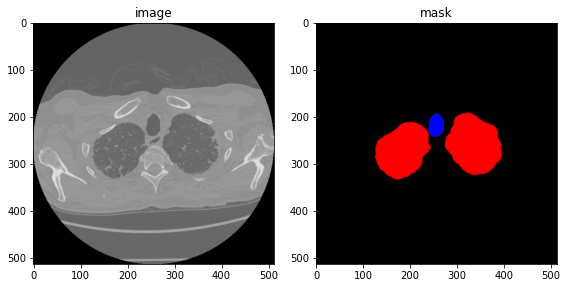

In [9]:
sub_index = 4
img_name, mask_name = client_data.iloc[sub_index].values
img_path = os.path.join(data_dir, "images", img_name)
mask_path = os.path.join(data_dir, "masks", mask_name)

image = cv2.imread(img_path)
mask = cv2.imread(mask_path)

plt.figure(figsize=(8,6))
plt.subplot(121)
plt.title("image")
plt.imshow(image)

plt.subplot(122)
plt.title("mask")
plt.imshow(mask)
plt.tight_layout()

In [10]:
# 순자척인 이미지인지 영상으로 만들어서 확인해보기
def get_client_data(data_df, index):
    client_ids = np.unique(data_df.id.values)
    client_id = client_ids[index]
    client_data = data_df[data_df.id == client_id]
    image_files = list(client_data["ImageId"])
    mask_files = list(client_data["MaskId"])
    return client_id, image_files, mask_files
# 특정 클라이언트가 촬영한 이미지와 마스크 데이터를 리스트 형태로 반환하는 함수

In [11]:
# 색깔 지정해주기
regions = ["background", "trachea", "heart", "lung"]
colors = ((0,0,0), (255,0,0), (0,255,0), (0,0,255)) # opencv 는 컬러 스페이스가 BGR임.
'''
segmentation 같은 경우에는 classification, detection, pose estimation 이런 부분과 좀 다르게
백그라운드에 대한 정보도 반드시 필요하다.
'''

'\nsegmentation 같은 경우에는 classification, detection, pose estimation 이런 부분과 좀 다르게\n백그라운드에 대한 정보도 반드시 필요하다.\n'

In [32]:
index = 0
client_id, image_files, mask_files = get_client_data(data_df, index)
print("client_id: ", client_id)

# 이미지들을 영상으로 만들어보기
canvas = np.zeros(shape=(512, 2*512*50, 3), dtype=np.uint8)
# 이미지를 순차적으로 불러와서 영상으로 띄워보기
for i in range(len(image_files)):
    image = cv2.imread(os.path.join(data_dir, "images", image_files[i]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(os.path.join(data_dir, "masks", mask_files[i]))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    # 파일 형태가 jpeg인데 엣지 부위가 픽셀이 오염됐기 때문에 임계값으로 변경
    # 명확하게 바이너리 형태로, 세그먼트 가능한 픽셀 단위의 클래시피케이션이 가능하도록 벨류값을 정리
    thres = 240
    mask[mask < thres] = 0
    mask[mask >= thres] = 255
    
    # 왼쪽부터 512까지는 이미지로 채울거고, 50의 공간을 띄우고 mask로 채움.
    canvas[:, 0:512, :] = image
    canvas[:, 512+50:2*512+50, :] = mask
    
    text_buff = 410 # 각각의 단어간에 마진을 두고 첫 위치를 text_buff에 담아서 출력
    for j in range(1, len(regions)):
        cv2.putText(canvas, f'{regions[j].upper()}', (900, text_buff), cv2.FONT_HERSHEY_SIMPLEX, 1, colors[j], 2)
        text_buff += 40
        
    cv2.imshow("CT frames", canvas)
    key = cv2.waitKey(200)
    if key == 27:
        break
cv2.destroyAllWindows()

client_id:  ID00007637202177411956430


# 2. 데이터셋 구축과 연산을 위한 텐서변환 모듈 작성하기

data_dir </br>
    ㄴ train</br>
        ㄴ images *.jpg</br>
      ㄴ masks *.jpg</br>
    ㄴ val</br>
        ㄴ images</br>
        ㄴ masks</br>

In [2]:
data_dir = "./DATASET/Segmentation/"

1. 이미지 형태가 마스크 데이터는 PNG면은 픽셀 엣지 단에서 픽셀값에 오염이 없고

  JPEG이나 다른 손실 기법으로 압축된 마스크의 이미지 데이터 같은 경우에는 엣지 단 혹은 코너 단에서 픽셀이 굉장히 뭉개지는 형태가 있기 때문에 그 점을 꼭 확인을 해야지 모델을 학습할 수 있습니다.


2. 이미지나 마스크를 모델의 입력단에 맞게끔 리사이즈를 할 때 이미지 같은 경우에는 사실 inter_linear이나 다른 보간법을 써도 되지만 마스크 같은 경우에는 linear한 보간법을 쓰면 안 되고 nearest 같은 비선형 근접한 픽셀로그 값을 무조건 채우는 형태로 리사이즈를 해야 한다.

  이유는 예를 들면 0과 10 사이의 값을 리사이즈를 통해서 이제 줄이거나 늘린다면 당연히 0과 10이 아니라 0과 10사이의 어떤 값이 생기겠죠

그러면은 이제 세그멘테이션 할 때 5라는 값은 분류할 타겟 값에 전혀 없었는데 5라는 값이 인풋으로 들어와서 네트워크가 학습할 때 혼동이 생길 수 있습니다.

그렇기 때문에 nearest로 0과 10 두 개 중에 근접한 픽셀은 10으로 채울지 0으로 채울지를 정하는 방식이 마스크 데이터를 리사이즈 할 때 꼭 필요한 방식입니다.

In [41]:
IMAGE_SIZE = 224

In [57]:
class CT_dataset():
    def __init__(self, data_dir, phase, transformer=None):
        self.phase = phase
        self.images_dir = os.path.join(data_dir, phase, "images")
        self.masks_dir = os.path.join(data_dir, phase, "masks")
        self.image_files = [filename for filename in os.listdir(self.images_dir) if filename.endswith("jpg")]
        self.mask_files = [filename for filename in os.listdir(self.masks_dir) if filename.endswith("jpg")]
        
        assert len(self.image_files) == len(self.mask_files) # 에러처리
        
        self.transformer = transformer
        
    def __len__(self,):
        return len(self.image_files)
    
    def __getitem__(self, index):
        image = cv2.imread(os.path.join(self.images_dir, self.image_files[index]))
        image = cv2.resize(image, dsize=(IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_LINEAR)
        mask = cv2.imread(os.path.join(self.masks_dir, self.mask_files[index]))
        mask = cv2.resize(mask, dsize=(IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
        
        mask[mask < 240] = 0
        mask[mask >= 240] = 255
        mask = mask / 255
        
        # 백그라운드에 대한 인덱스값을 별도로 지정해주어야 한다.
        # 세그멘테이션은 백그라운드로 인식을 하기 위한 학습을 위한 데이터가 필요하다. 
        mask_H, mask_W, mask_C = mask.shape
        background = np.ones(shape=(mask_H, mask_W)) # 기존 마스크 데이터셋에 패딩을 해서 4채널짜리로 만들기.
        background[mask[..., 0] != 0] = 0
        background[mask[..., 1] != 0] = 0
        background[mask[..., 2] != 0] = 0
        mask = np.concatenate([np.expand_dims(background, axis=-1), mask], axis=-1)
        mask = np.argmax(mask, axis=-1)
        
        if self.transformer:
            image = self.transformer(image)
            
        target = torch.from_numpy(mask).long()
        return image, target

In [43]:
from torchvision import transforms

def build_transformer():
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return transformer

collate 평션을 하는 역할은 배치 형태로 이미지가 구성이 될 때 배치 형태를 어떻게 구성을 할 건지, 개개의 이미지나 라벨이나 마스크 데이터셋을 어떻게 미니 배치 형태로 구성을 할 건지를 콜레이트 펑션을 통해서 데이터 로더에 전달 할 수가 있고

그러면은 데이터 로더에서 값을 반환할 때 콜레이트 펑션을 통해서 반환되는 형태의 입력 이미지를 반환을 합니다.

In [44]:
def collate_fn(batch):
    images = []
    targets = []
    for a, b in batch:
        images.append(a)
        targets.append(b)
        
    images = torch.stack(images, dim=0)
    targets = torch.stack(targets, dim=0)
    return images, targets

In [58]:
data_dir = "./DATASET/Segmentation/"
transformer = build_transformer()
dset = CT_dataset(data_dir=data_dir, phase="train", transformer=transformer)

In [59]:
image, target = dset[0]
print(f"image shape: {image.shape}")
print(f"target shape: {target.shape}")

image shape: torch.Size([3, 224, 224])
target shape: torch.Size([224, 224])


In [60]:
target.unique()

tensor([0])

In [61]:
from torch.utils.data import DataLoader

In [62]:
dloader = DataLoader(dset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [64]:
for index, batch in enumerate(dloader):
    images = batch[0]
    targets = batch[1]
    print(f"images shape: {images.shape}")
    print(f"targets shape: {targets.shape}")
    
    if index==0:
        break

images shape: torch.Size([4, 3, 224, 224])
targets shape: torch.Size([4, 224, 224])


In [69]:
def build_dataloader(data_dir, batch_size=4):
    transformer = build_transformer()
    
    dataloaders = {}
    train_dataset = CT_dataset(data_dir=data_dir, phase="train", transformer=transformer)
    dataloaders["train"] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    
    val_dataset = CT_dataset(data_dir=data_dir, phase="val", transformer=transformer)
    dataloaders["val"] = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    
    return dataloaders

In [70]:
data_dir = "./DATASET/Segmentation/"
dataloaders = build_dataloader(data_dir=data_dir)

for phase in ["train", "val"]:
    for index, batch in enumerate(dataloaders[phase]):
        images = batch[0]
        targets = batch[1]
        print(f"images shape: {images.shape}")
        print(f"targets shape: {targets.shape}")
        if index==0:
            break

images shape: torch.Size([4, 3, 224, 224])
targets shape: torch.Size([4, 224, 224])
images shape: torch.Size([1, 3, 224, 224])
targets shape: torch.Size([1, 224, 224])
